# Imports

In [1]:
!pip install -q tfds-nightly tensorflow-datasets tensorflow matplotlib

     |████████████████████████████████| 4.1 MB 4.1 MB/s 


In [2]:
import tensorflow as tf
import cv2
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load dataset

Import dataset

In [3]:
ds = tfds.load('deep_weeds', batch_size = -1, as_supervised= True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/17509 [00:00<?, ? examples/s]

Shuffling deep_weeds-train.tfrecord...:   0%|          | 0/17509 [00:00<?, ? examples/s]

Dataset deep_weeds downloaded and prepared to /root/tensorflow_datasets/deep_weeds/3.0.0. Subsequent calls will reuse this data.


In [4]:
images, labels = ds['train']

# Preprocessing

In [5]:
print(images.shape)
print(images.dtype)

(17509, 256, 256, 3)
<dtype: 'uint8'>


We're definitely not going to run KNN on 256\*256\*3, so let's downres it to 64*64

In [6]:
resized_images = tf.image.resize(images, [64,64])
resized_images_32 = tf.image.resize(images, [32,32])
image_vectors = tf.reshape(resized_images_32, [-1,3072])

In [7]:
print(resized_images.shape)

(17509, 64, 64, 3)


In [8]:
print(image_vectors.shape)

(17509, 3072)


Edge detection

In [9]:
edges = tf.image.sobel_edges(tf.cast(tf.image.rgb_to_grayscale(resized_images), tf.float32))

In [10]:
edges_combined = tf.sqrt(tf.math.reduce_sum(edges**2, axis=-1))

In [11]:
edges_combined_scaled = tf.divide(tf.subtract(edges_combined, tf.reduce_min(edges_combined)), tf.subtract(tf.reduce_max(edges_combined), tf.reduce_min(edges_combined)))*255

In [12]:
print(tf.math.reduce_max(edges_combined_scaled))

tf.Tensor(255.0, shape=(), dtype=float32)


Here's a sample of an image after downres

Text(0.5, 1.0, 'After')

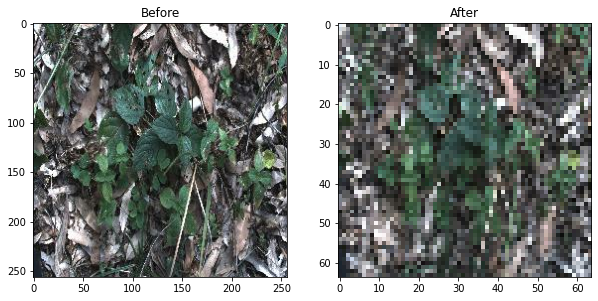

In [13]:
before = images[0]
after = tf.cast(resized_images[0], tf.uint8)

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,2,1)
plt.imshow(before)
ax.set_title("Before")

ax = fig.add_subplot(1,2,2)
plt.imshow(after)
ax.set_title("After")

sample of image after edge detection

Text(0.5, 1.0, 'AfterC')

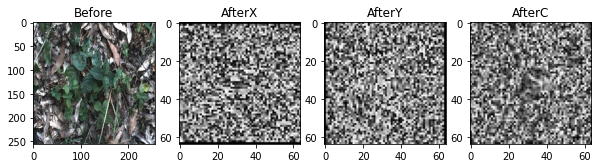

In [14]:
before = images[0]
after = tf.cast(edges[0], tf.uint8)
afterc = tf.cast(edges_combined[0], tf.uint8)
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,4,1)
plt.imshow(before)
ax.set_title("Before")

ax = fig.add_subplot(1,4,2)
plt.imshow(after[:,:,0,0], cmap='gray', vmin=0, vmax=255)
ax.set_title("AfterX")

ax = fig.add_subplot(1,4,3)
plt.imshow(after[:,:,0,1], cmap='gray', vmin=0, vmax=255)
ax.set_title("AfterY")

ax = fig.add_subplot(1,4,4)
plt.imshow(afterc[:,:,0], cmap='gray', vmin=0, vmax=255)
ax.set_title("AfterC")

The result is pretty undiscernible, so expected accuracy should be quite bad

LDA dimensionality reduction

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [16]:
clf = LinearDiscriminantAnalysis()
print(edges_combined_scaled.shape)
edges_vectors = tf.reshape(edges_combined_scaled, [-1,4096])
clf.fit(edges_vectors, labels)

(17509, 64, 64, 1)


LinearDiscriminantAnalysis()

In [17]:
LDA_features = clf.transform(edges_vectors)

In [18]:
print(LDA_features.shape)

(17509, 8)


Huge dimensionality reduction from 4096 to 8

#pure KNN with 1 nearest neighbour on 64\*64\*3 pixels

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_vectors.numpy(), labels.numpy(), test_size=0.2)

In [20]:
from sklearn import neighbors
from sklearn.metrics import classification_report

In [21]:
knn = neighbors.KNeighborsClassifier(n_neighbors = 1, metric='euclidean')
knn_model = knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.09      0.35      0.15       220
           1       0.12      0.02      0.03       199
           2       0.21      0.06      0.09       215
           3       0.13      0.01      0.02       196
           4       0.10      0.02      0.04       220
           5       0.75      0.01      0.03       205
           6       0.08      0.23      0.12       200
           7       0.12      0.08      0.09       188
           8       0.62      0.61      0.61      1859

    accuracy                           0.37      3502
   macro avg       0.25      0.16      0.13      3502
weighted avg       0.42      0.37      0.36      3502



#LDA on pixels

In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [23]:
clf = LinearDiscriminantAnalysis()
clf.fit(image_vectors, labels)

LinearDiscriminantAnalysis()

In [24]:
LDA_pixels = clf.transform(image_vectors)

In [25]:
print(LDA_pixels.shape)

(17509, 8)


#KNN on 32\*32\*3 pixels with LDA with CV and undersampling

In [97]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(LDA_pixels, labels.numpy(), test_size=0.2)

In [98]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import neighbors

In [99]:
undersampler = RandomUnderSampler()
knn = neighbors.KNeighborsClassifier(n_neighbors = 1, metric='euclidean')
im_pipeline = make_pipeline(undersampler, knn)
print(im_pipeline.get_params().keys())
print(knn.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'randomundersampler', 'kneighborsclassifier', 'randomundersampler__random_state', 'randomundersampler__replacement', 'randomundersampler__sampling_strategy', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])
dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])


In [100]:
params = {'kneighborsclassifier__n_neighbors':[x for x in range(1, 200) if x%2 != 0]}
grid_im = GridSearchCV(im_pipeline, param_grid=params, cv=5)
grid_im.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('randomundersampler',
                                        RandomUnderSampler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(metric='euclidean',
                                                             n_neighbors=1))]),
             param_grid={'kneighborsclassifier__n_neighbors': [1, 3, 5, 7, 9,
                                                               11, 13, 15, 17,
                                                               19, 21, 23, 25,
                                                               27, 29, 31, 33,
                                                               35, 37, 39, 41,
                                                               43, 45, 47, 49,
                                                               51, 53, 55, 57,
                                                               59, ...]})

In [101]:
print(grid_im.best_params_)
print(grid_im.best_score_)
print(grid_im.cv_results_['mean_test_score'])

{'kneighborsclassifier__n_neighbors': 197}
0.6136931059341763
[0.48268728 0.48597134 0.515599   0.54072974 0.55407926 0.5639325
 0.57135733 0.57756899 0.57785427 0.58435103 0.58856302 0.58320828
 0.58477881 0.58684914 0.58492098 0.59091846 0.59113251 0.58399267
 0.59006233 0.58991973 0.58963369 0.59427389 0.5925605  0.59584445
 0.59555933 0.59006264 0.59691527 0.59798542 0.59306014 0.59420267
 0.59584491 0.59720091 0.59448823 0.59812882 0.59741558 0.60005627
 0.60127055 0.60269849 0.59777178 0.60212718 0.60034218 0.59969999
 0.60248372 0.60491173 0.59991471 0.60212675 0.60269793 0.60269793
 0.60112668 0.60141213 0.60598165 0.60048527 0.59805848 0.60262734
 0.60412645 0.61026632 0.60519688 0.60883772 0.60291231 0.6083378
 0.6030556  0.60433979 0.60112792 0.60797979 0.60248423 0.60862331
 0.60726691 0.60583918 0.60319813 0.60705354 0.6049105  0.60319843
 0.60726775 0.60626821 0.6047693  0.60484027 0.6108379  0.6061954
 0.60698132 0.6092664  0.60591068 0.60198412 0.60691053 0.60776739
 0.

Text(0, 0.5, 'mean test scores')

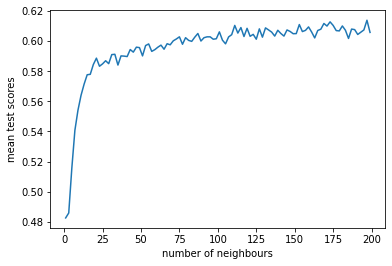

In [102]:
plt.plot([x for x in range(1, 200) if x%2 != 0],grid_im.cv_results_['mean_test_score'])
plt.xlabel('number of neighbours')
plt.ylabel('mean test scores')

In [103]:
params = {'n_neighbors':[x for x in range(1, 200) if x%2 != 0]}
grid_im = GridSearchCV(knn, param_grid=params, cv=5)
grid_im.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=KNeighborsClassifier(metric='euclidean', n_neighbors=1),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29, 31, 33, 35, 37, 39, 41,
                                         43, 45, 47, 49, 51, 53, 55, 57, 59, ...]})

In [104]:
print(grid_im.best_params_)
print(grid_im.best_score_)
print(grid_im.cv_results_['mean_test_score'])

{'n_neighbors': 27}
0.7259227037554905
[0.61762015 0.65638656 0.69222578 0.70664681 0.71192954 0.71892599
 0.7202826  0.72056811 0.72413778 0.72478053 0.72478046 0.72385222
 0.72485153 0.7259227  0.72535153 0.72320992 0.72385247 0.72320997
 0.72221041 0.72171064 0.72163944 0.72213931 0.72235339 0.72113987
 0.72014046 0.71956933 0.71999765 0.71849826 0.71949791 0.7186413
 0.71821285 0.71699908 0.71678467 0.71735589 0.71592798 0.71664176
 0.71621349 0.71628502 0.71678477 0.7164278  0.7157137  0.71492836
 0.71385755 0.71364321 0.71428581 0.71314354 0.71250097 0.7127153
 0.71200132 0.71193002 0.71193007 0.71150173 0.71128755 0.71150173
 0.71178729 0.71150168 0.71064507 0.7088601  0.70864617 0.70800336
 0.70814624 0.708289   0.70807471 0.70771777 0.70800334 0.70771783
 0.70686119 0.70686119 0.70586165 0.70593311 0.70493354 0.70486214
 0.70479076 0.70464795 0.70407675 0.70322022 0.70300599 0.70300591
 0.70243476 0.7027204  0.70222068 0.70114979 0.70122119 0.70015037
 0.70015037 0.7006502  0.

Text(0, 0.5, 'mean test scores')

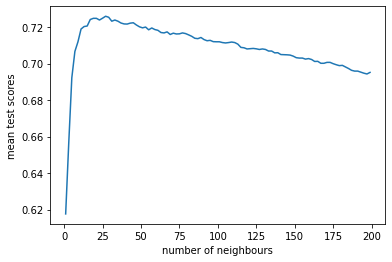

In [105]:
plt.plot([x for x in range(1, 200) if x%2 != 0],grid_im.cv_results_['mean_test_score'])
plt.xlabel('number of neighbours')
plt.ylabel('mean test scores')

Actual Model:

In [248]:
from sklearn import neighbors
from sklearn.metrics import classification_report

In [249]:
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler()
X_train_U, y_train_U = undersampler.fit_resample(X_train, y_train)

In [250]:
knn = neighbors.KNeighborsClassifier(n_neighbors = 27, metric='euclidean')
knn_model = knn.fit(X_train_U, y_train_U)
y_pred_knn = knn.predict(X_test)
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.49      0.65      0.56       226
           1       0.66      0.80      0.73       225
           2       0.35      0.78      0.48       201
           3       0.58      0.73      0.64       213
           4       0.39      0.72      0.51       216
           5       0.54      0.69      0.61       196
           6       0.49      0.81      0.61       231
           7       0.45      0.63      0.53       187
           8       0.94      0.48      0.63      1807

    accuracy                           0.60      3502
   macro avg       0.54      0.70      0.59      3502
weighted avg       0.72      0.60      0.61      3502



Without undersampling

Text(0.5, 33.0, 'Predicted')

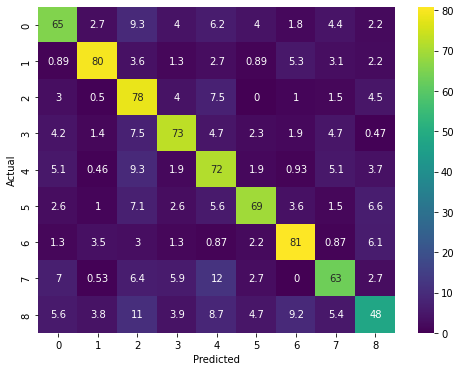

In [251]:
import pandas as pd
import seaborn as sns
confusion_matrix = np.zeros((9, 9), dtype = np.float64)
for i in range(len(y_test)):
  predicted = y_pred_knn[i]
  actual = y_test[i]
  confusion_matrix[actual][predicted] += 1
  _, counts = np.unique(y_test, return_counts = True)
for row in range(9):
  for col in range(9):
    confusion_matrix[row][col] /= counts[row]
    confusion_matrix[row][col] *= 100
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix, annot = True, cmap='viridis', ax = ax)
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

In [252]:
from sklearn import neighbors
from sklearn.metrics import classification_report

In [253]:
knn = neighbors.KNeighborsClassifier(n_neighbors = 29, metric='euclidean')
knn_model = knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.74      0.50      0.60       226
           1       0.93      0.60      0.73       225
           2       0.67      0.47      0.56       201
           3       0.77      0.58      0.66       213
           4       0.62      0.49      0.54       216
           5       0.79      0.41      0.54       196
           6       0.88      0.46      0.61       231
           7       0.70      0.47      0.56       187
           8       0.71      0.94      0.81      1807

    accuracy                           0.73      3502
   macro avg       0.76      0.55      0.62      3502
weighted avg       0.74      0.73      0.71      3502



Text(0.5, 33.0, 'Predicted')

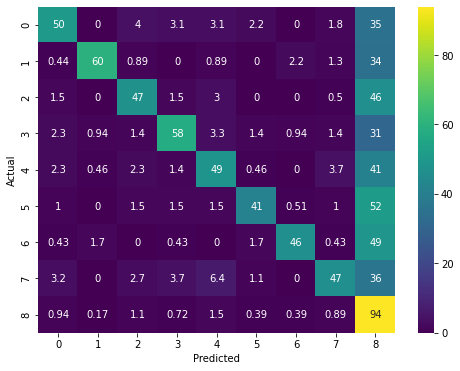

In [254]:
import pandas as pd
import seaborn as sns
confusion_matrix = np.zeros((9, 9), dtype = np.float64)
for i in range(len(y_test)):
  predicted = y_pred_knn[i]
  actual = y_test[i]
  confusion_matrix[actual][predicted] += 1
  _, counts = np.unique(y_test, return_counts = True)
for row in range(9):
  for col in range(9):
    confusion_matrix[row][col] /= counts[row]
    confusion_matrix[row][col] *= 100
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix, annot = True, cmap='viridis', ax = ax)
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

#KNN on engineered features with CV and undersampling

In [111]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(LDA_features, labels.numpy(), test_size=0.2)

In [112]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import neighbors

In [113]:
undersampler = RandomUnderSampler()
knn = neighbors.KNeighborsClassifier(n_neighbors = 1, metric='euclidean')
im_pipeline = make_pipeline(undersampler, knn)
print(im_pipeline.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'randomundersampler', 'kneighborsclassifier', 'randomundersampler__random_state', 'randomundersampler__replacement', 'randomundersampler__sampling_strategy', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])


In [114]:
params = {'kneighborsclassifier__n_neighbors':[x for x in range(1, 200) if x%2 != 0]}
grid_im = GridSearchCV(im_pipeline, param_grid=params, cv=10)
grid_im.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('randomundersampler',
                                        RandomUnderSampler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(metric='euclidean',
                                                             n_neighbors=1))]),
             param_grid={'kneighborsclassifier__n_neighbors': [1, 3, 5, 7, 9,
                                                               11, 13, 15, 17,
                                                               19, 21, 23, 25,
                                                               27, 29, 31, 33,
                                                               35, 37, 39, 41,
                                                               43, 45, 47, 49,
                                                               51, 53, 55, 57,
                                                               59, ...]})

In [115]:
print(grid_im.best_params_)
print(grid_im.best_score_)
print(grid_im.cv_results_['mean_test_score'])

{'kneighborsclassifier__n_neighbors': 199}
0.6316125726521872
[0.48682594 0.49068196 0.52973473 0.54972489 0.56571678 0.5697877
 0.57771077 0.58263812 0.5857073  0.58777689 0.59291705 0.59541506
 0.59805945 0.60155634 0.60319823 0.60469736 0.60641078 0.60733864
 0.61105231 0.60848103 0.61026624 0.61476476 0.61333481 0.61112445
 0.61383558 0.60691078 0.61233685 0.61333573 0.61504884 0.61069343
 0.61654838 0.61597726 0.61919088 0.61683277 0.61604869 0.61776139
 0.62382966 0.61819114 0.62097532 0.62118859 0.62011721 0.61833287
 0.61861844 0.62482798 0.62047446 0.62026134 0.62154517 0.62247405
 0.62083221 0.62725686 0.6235442  0.62211619 0.62275946 0.61990425
 0.62154349 0.62247232 0.62304339 0.62418655 0.62604216 0.62140186
 0.62061533 0.62418686 0.62397186 0.62026104 0.62554354 0.62190226
 0.62582925 0.62911339 0.62247359 0.61976043 0.6249717  0.625829
 0.62525716 0.6304687  0.6276841  0.62925451 0.62504329 0.62304446
 0.62468584 0.62804211 0.62568579 0.62932681 0.62768426 0.62954145
 0.

Text(0, 0.5, 'mean test scores')

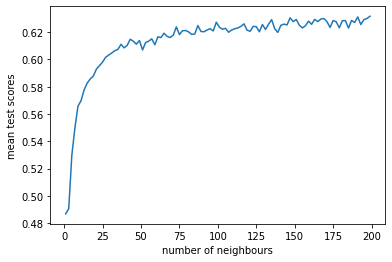

In [116]:
plt.plot([x for x in range(1, 200) if x%2 != 0],grid_im.cv_results_['mean_test_score'])
plt.xlabel('number of neighbours')
plt.ylabel('mean test scores')

In [117]:
params = {'n_neighbors':[x for x in range(1, 200) if x%2 != 0]}
grid_im = GridSearchCV(knn, param_grid=params, cv=5)
grid_im.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=KNeighborsClassifier(metric='euclidean', n_neighbors=1),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29, 31, 33, 35, 37, 39, 41,
                                         43, 45, 47, 49, 51, 53, 55, 57, 59, ...]})

In [118]:
print(grid_im.best_params_)
print(grid_im.best_score_)
print(grid_im.cv_results_['mean_test_score'])

{'n_neighbors': 21}
0.7379161770765565
[0.63682337 0.68094481 0.70985867 0.72485107 0.73013429 0.73434661
 0.73520291 0.73655939 0.73784475 0.73620273 0.73791618 0.73713115
 0.73684559 0.7366313  0.73534628 0.73577457 0.73613148 0.7354176
 0.73498926 0.73448962 0.73327592 0.73356143 0.73306166 0.73334712
 0.73141931 0.73084834 0.72963457 0.72920617 0.72899197 0.72856357
 0.72742112 0.72727839 0.72713559 0.7263502  0.7263502  0.72520783
 0.72542199 0.72470821 0.72442265 0.72356592 0.72228094 0.72256645
 0.721924   0.72206673 0.72113862 0.72099582 0.72099584 0.72042462
 0.72035324 0.71963931 0.71963934 0.718854   0.71771178 0.71664084
 0.71706923 0.71656941 0.71592689 0.71599839 0.71535599 0.71485625
 0.71485615 0.71428512 0.7143563  0.71442788 0.71321418 0.71314278
 0.71278586 0.7118577  0.71164354 0.71014428 0.70964454 0.70900191
 0.70864492 0.70807377 0.70750262 0.70714568 0.70650313 0.70571778
 0.70593201 0.7056465  0.70493255 0.70464696 0.70443275 0.70414719
 0.7032192  0.70236232 0

Text(0, 0.5, 'mean test scores')

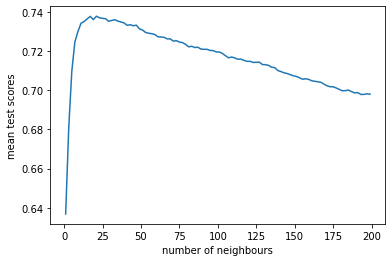

In [119]:
plt.plot([x for x in range(1, 200) if x%2 != 0],grid_im.cv_results_['mean_test_score'])
plt.xlabel('number of neighbours')
plt.ylabel('mean test scores')

Actual Model:

In [255]:
from sklearn import neighbors
from sklearn.metrics import classification_report

In [256]:
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler()
X_train_U, y_train_U = undersampler.fit_resample(X_train, y_train)

In [257]:
knn = neighbors.KNeighborsClassifier(n_neighbors = 27, metric='euclidean')
knn_model = knn.fit(X_train_U, y_train_U)
y_pred_knn = knn.predict(X_test)
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.50      0.68      0.58       226
           1       0.68      0.79      0.73       225
           2       0.36      0.77      0.49       201
           3       0.57      0.72      0.64       213
           4       0.37      0.69      0.48       216
           5       0.55      0.68      0.61       196
           6       0.48      0.79      0.60       231
           7       0.47      0.60      0.53       187
           8       0.91      0.49      0.64      1807

    accuracy                           0.60      3502
   macro avg       0.54      0.69      0.59      3502
weighted avg       0.71      0.60      0.61      3502



Text(0.5, 33.0, 'Predicted')

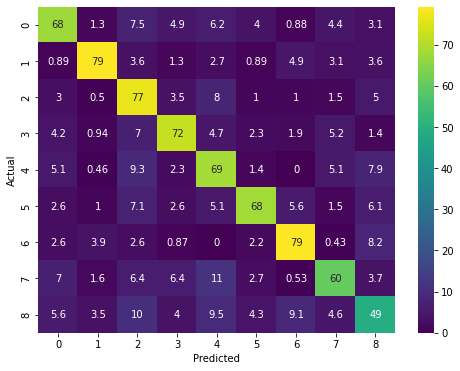

In [258]:
import pandas as pd
import seaborn as sns
confusion_matrix = np.zeros((9, 9), dtype = np.float64)
for i in range(len(y_test)):
  predicted = y_pred_knn[i]
  actual = y_test[i]
  confusion_matrix[actual][predicted] += 1
  _, counts = np.unique(y_test, return_counts = True)
for row in range(9):
  for col in range(9):
    confusion_matrix[row][col] /= counts[row]
    confusion_matrix[row][col] *= 100
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix, annot = True, cmap='viridis', ax = ax)
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

Without undersampling

In [259]:
from sklearn import neighbors
from sklearn.metrics import classification_report

In [260]:
knn = neighbors.KNeighborsClassifier(n_neighbors = 23, metric='euclidean')
knn_model = knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.72      0.51      0.60       226
           1       0.93      0.62      0.74       225
           2       0.66      0.48      0.56       201
           3       0.76      0.59      0.67       213
           4       0.62      0.47      0.54       216
           5       0.77      0.45      0.57       196
           6       0.83      0.48      0.61       231
           7       0.72      0.47      0.57       187
           8       0.72      0.93      0.81      1807

    accuracy                           0.73      3502
   macro avg       0.75      0.56      0.63      3502
weighted avg       0.73      0.73      0.71      3502



Text(0.5, 33.0, 'Predicted')

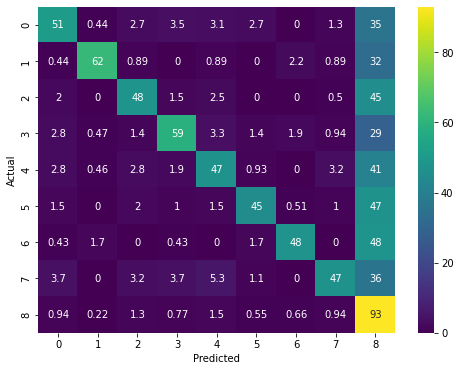

In [261]:
import pandas as pd
import seaborn as sns
confusion_matrix = np.zeros((9, 9), dtype = np.float64)
for i in range(len(y_test)):
  predicted = y_pred_knn[i]
  actual = y_test[i]
  confusion_matrix[actual][predicted] += 1
  _, counts = np.unique(y_test, return_counts = True)
for row in range(9):
  for col in range(9):
    confusion_matrix[row][col] /= counts[row]
    confusion_matrix[row][col] *= 100
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix, annot = True, cmap='viridis', ax = ax)
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

#SVM on pixels with LDA with CV and Undersampling

In [234]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(LDA_pixels, labels.numpy(), test_size=0.2)

In [235]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import svm

In [236]:
undersampler = RandomUnderSampler()
svmclf = svm.SVC(kernel='rbf')
im_pipeline = make_pipeline(undersampler, svmclf)
print(im_pipeline.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'randomundersampler', 'svc', 'randomundersampler__random_state', 'randomundersampler__replacement', 'randomundersampler__sampling_strategy', 'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose'])


In [237]:
params = {'svc__kernel':['rbf'],'svc__C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_im = GridSearchCV(im_pipeline, param_grid=params, cv=5)
grid_im.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('randomundersampler',
                                        RandomUnderSampler()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'svc__kernel': ['rbf']})

In [238]:
print(grid_im.best_params_)
print(grid_im.best_score_)
print(grid_im.cv_results_['mean_test_score'])

{'svc__C': 0.0001, 'svc__kernel': 'rbf'}
0.6341819901681898
[0.63418199 0.63239694 0.63218273 0.62861352 0.61876099 0.59213157
 0.54351321 0.48332871]


Text(0, 0.5, 'mean test scores')

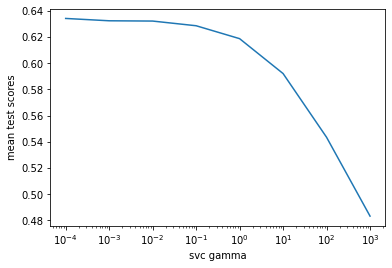

In [239]:
plt.plot([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],grid_im.cv_results_['mean_test_score'])
plt.xscale("log")
plt.xlabel('svc gamma')
plt.ylabel('mean test scores')

In [240]:
params = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_im = GridSearchCV(svmclf, param_grid=params, cv=5)
grid_im.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]})

In [241]:
print(grid_im.best_params_)
print(grid_im.best_score_)
print(grid_im.cv_results_['mean_test_score'])

{'C': 1}
0.7408435500628027
[0.5210966  0.5210966  0.52159637 0.732705   0.74084355 0.73056278
 0.69015471 0.65160215]


Text(0, 0.5, 'mean test scores')

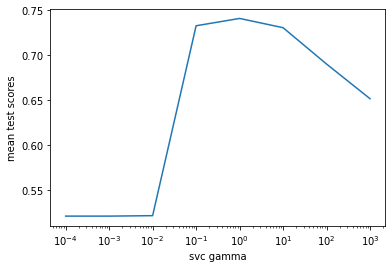

In [242]:
plt.plot([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],grid_im.cv_results_['mean_test_score'])
plt.xscale("log")
plt.xlabel('svc gamma')
plt.ylabel('mean test scores')

Actual Model:

In [262]:
from sklearn import svm
from sklearn.metrics import classification_report

In [263]:
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler()
X_train_U, y_train_U = undersampler.fit_resample(X_train, y_train)

In [264]:
clf = svm.SVC(kernel='rbf', C = 0.001)
clf.fit(X_train_U, y_train_U)
y_pred_svm = clf.predict(X_test)
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.55      0.69      0.61       226
           1       0.64      0.83      0.73       225
           2       0.43      0.75      0.55       201
           3       0.56      0.73      0.63       213
           4       0.46      0.69      0.55       216
           5       0.57      0.74      0.65       196
           6       0.54      0.71      0.62       231
           7       0.46      0.71      0.56       187
           8       0.90      0.56      0.69      1807

    accuracy                           0.65      3502
   macro avg       0.57      0.71      0.62      3502
weighted avg       0.72      0.65      0.65      3502



Text(0.5, 33.0, 'Predicted')

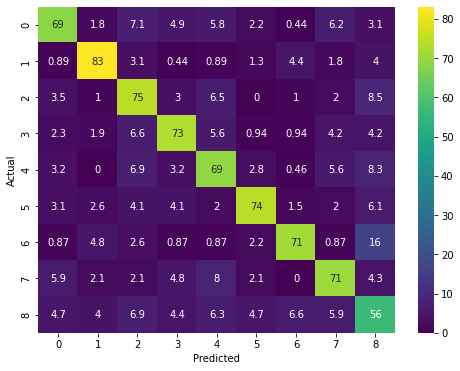

In [265]:
import pandas as pd
import seaborn as sns
confusion_matrix = np.zeros((9, 9), dtype = np.float64)
for i in range(len(y_test)):
  predicted = y_pred_svm[i]
  actual = y_test[i]
  confusion_matrix[actual][predicted] += 1
  _, counts = np.unique(y_test, return_counts = True)
for row in range(9):
  for col in range(9):
    confusion_matrix[row][col] /= counts[row]
    confusion_matrix[row][col] *= 100
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix, annot = True, cmap='viridis', ax = ax)
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

Without undersampling

In [266]:
from sklearn import svm
from sklearn.metrics import classification_report

In [267]:
clf = svm.SVC(kernel='rbf', C = 1)
clf.fit(X_train, y_train)
y_pred_svm = clf.predict(X_test)
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.70      0.59      0.64       226
           1       0.85      0.68      0.76       225
           2       0.75      0.49      0.59       201
           3       0.76      0.60      0.67       213
           4       0.66      0.53      0.59       216
           5       0.75      0.47      0.58       196
           6       0.83      0.50      0.62       231
           7       0.68      0.55      0.61       187
           8       0.74      0.92      0.82      1807

    accuracy                           0.74      3502
   macro avg       0.75      0.59      0.65      3502
weighted avg       0.75      0.74      0.73      3502



Text(0.5, 33.0, 'Predicted')

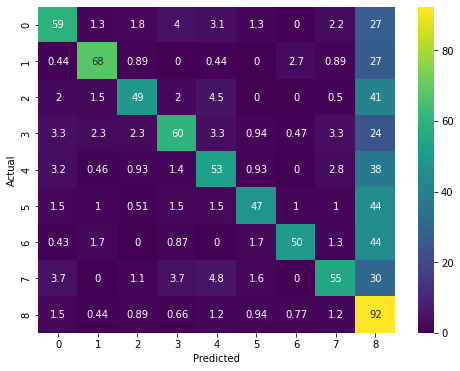

In [268]:
import pandas as pd
import seaborn as sns
confusion_matrix = np.zeros((9, 9), dtype = np.float64)
for i in range(len(y_test)):
  predicted = y_pred_svm[i]
  actual = y_test[i]
  confusion_matrix[actual][predicted] += 1
  _, counts = np.unique(y_test, return_counts = True)
for row in range(9):
  for col in range(9):
    confusion_matrix[row][col] /= counts[row]
    confusion_matrix[row][col] *= 100
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix, annot = True, cmap='viridis', ax = ax)
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

#SVM on engineered features with LDA with CV and Undersampling

In [140]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(LDA_features, labels.numpy(), test_size=0.2)

In [141]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import svm

In [142]:
undersampler = RandomUnderSampler()
svmclf = svm.SVC(kernel='rbf')
im_pipeline = make_pipeline(undersampler, svmclf)
print(im_pipeline.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'randomundersampler', 'svc', 'randomundersampler__random_state', 'randomundersampler__replacement', 'randomundersampler__sampling_strategy', 'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose'])


In [143]:
params = {'svc__kernel':['rbf'],'svc__C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_im = GridSearchCV(im_pipeline, param_grid=params, cv=5)
grid_im.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('randomundersampler',
                                        RandomUnderSampler()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'svc__kernel': ['rbf']})

In [144]:
print(grid_im.best_params_)
print(grid_im.best_score_)
print(grid_im.cv_results_['mean_test_score'])

{'svc__C': 0.0001, 'svc__kernel': 'rbf'}
0.6401802048366024
[0.6401802  0.63968031 0.63496829 0.62668668 0.61233708 0.59263241
 0.54372783 0.49346715]


Text(0, 0.5, 'mean test scores')

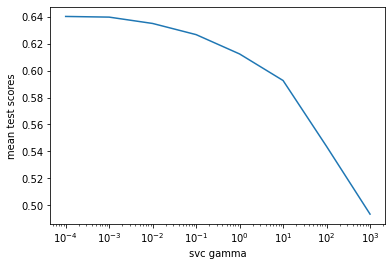

In [145]:
plt.plot([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],grid_im.cv_results_['mean_test_score'])
plt.xscale("log")
plt.xlabel('svc gamma')
plt.ylabel('mean test scores')

In [146]:
params = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_im = GridSearchCV(svmclf, param_grid=params, cv=5)
grid_im.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]})

In [147]:
print(grid_im.best_params_)
print(grid_im.best_score_)
print(grid_im.cv_results_['mean_test_score'])

{'C': 1}
0.7502675321676946
[0.52023987 0.52023987 0.52281012 0.74762613 0.75026753 0.73977301
 0.70814566 0.66188386]


Text(0, 0.5, 'mean test scores')

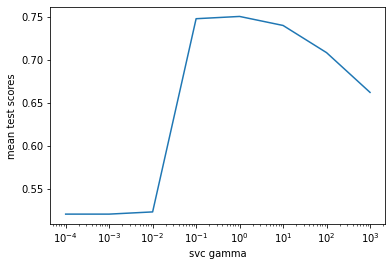

In [148]:
plt.plot([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],grid_im.cv_results_['mean_test_score'])
plt.xscale("log")
plt.xlabel('svc gamma')
plt.ylabel('mean test scores')

Actual Model:

In [269]:
from sklearn import svm
from sklearn.metrics import classification_report

In [270]:
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler()
X_train_U, y_train_U = undersampler.fit_resample(X_train, y_train)

In [271]:
clf = svm.SVC(kernel='rbf', C = 0.001)
clf.fit(X_train_U, y_train_U)
y_pred_svm = clf.predict(X_test)
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.53      0.70      0.60       226
           1       0.63      0.83      0.72       225
           2       0.43      0.75      0.55       201
           3       0.55      0.73      0.63       213
           4       0.46      0.69      0.55       216
           5       0.57      0.73      0.64       196
           6       0.56      0.70      0.62       231
           7       0.46      0.71      0.56       187
           8       0.90      0.56      0.69      1807

    accuracy                           0.64      3502
   macro avg       0.57      0.71      0.62      3502
weighted avg       0.72      0.64      0.65      3502



Text(0.5, 33.0, 'Predicted')

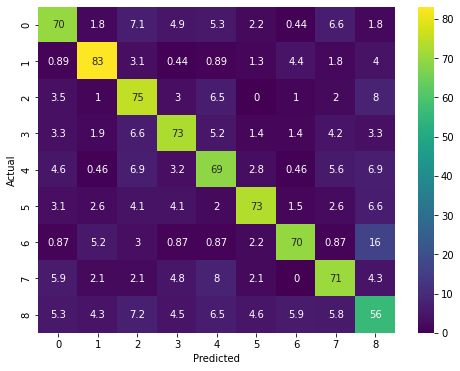

In [272]:
import pandas as pd
import seaborn as sns
confusion_matrix = np.zeros((9, 9), dtype = np.float64)
for i in range(len(y_test)):
  predicted = y_pred_svm[i]
  actual = y_test[i]
  confusion_matrix[actual][predicted] += 1
  _, counts = np.unique(y_test, return_counts = True)
for row in range(9):
  for col in range(9):
    confusion_matrix[row][col] /= counts[row]
    confusion_matrix[row][col] *= 100
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix, annot = True, cmap='viridis', ax = ax)
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

Without undersampling

In [273]:
from sklearn import svm
from sklearn.metrics import classification_report

In [274]:
clf = svm.SVC(kernel='rbf', C = 1)
clf.fit(X_train, y_train)
y_pred_svm = clf.predict(X_test)
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.70      0.59      0.64       226
           1       0.85      0.68      0.76       225
           2       0.75      0.49      0.59       201
           3       0.76      0.60      0.67       213
           4       0.66      0.53      0.59       216
           5       0.75      0.47      0.58       196
           6       0.83      0.50      0.62       231
           7       0.68      0.55      0.61       187
           8       0.74      0.92      0.82      1807

    accuracy                           0.74      3502
   macro avg       0.75      0.59      0.65      3502
weighted avg       0.75      0.74      0.73      3502



Text(0.5, 33.0, 'Predicted')

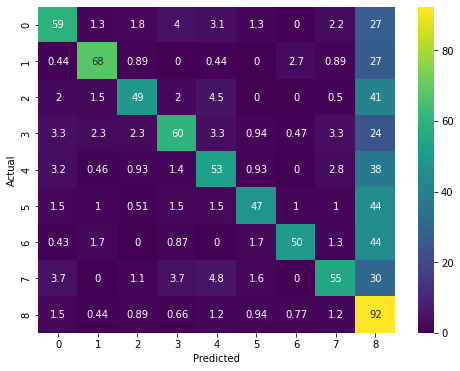

In [275]:
import pandas as pd
import seaborn as sns
confusion_matrix = np.zeros((9, 9), dtype = np.float64)
for i in range(len(y_test)):
  predicted = y_pred_svm[i]
  actual = y_test[i]
  confusion_matrix[actual][predicted] += 1
  _, counts = np.unique(y_test, return_counts = True)
for row in range(9):
  for col in range(9):
    confusion_matrix[row][col] /= counts[row]
    confusion_matrix[row][col] *= 100
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix, annot = True, cmap='viridis', ax = ax)
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

#Random Forest on pixels with LDA with CV and Undersampling

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(LDA_pixels, labels.numpy(), test_size=0.2)

In [ ]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [161]:
undersampler = RandomUnderSampler()
clf=RandomForestClassifier()
im_pipeline = make_pipeline(undersampler, clf)
print(im_pipeline.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'randomundersampler', 'randomforestclassifier', 'randomundersampler__random_state', 'randomundersampler__replacement', 'randomundersampler__sampling_strategy', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__max_samples', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_samples_leaf', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__min_weight_fraction_leaf', 'randomforestclassifier__n_estimators', 'randomforestclassifier__n_jobs', 'randomforestclassifier__oob_score', 'randomforestclassifier__random_state', 'randomforestclassifier__verbose', 'randomforestclassifier__warm_start'])


In [165]:
params = {'randomforestclassifier__max_depth':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
grid_im = GridSearchCV(im_pipeline, param_grid=params, cv=5)
grid_im.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('randomundersampler',
                                        RandomUnderSampler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             param_grid={'randomforestclassifier__max_depth': [10, 20, 30, 40,
                                                               50, 60, 70, 80,
                                                               90, 100]})

In [166]:
print(grid_im.best_params_)
print(grid_im.best_score_)
print(grid_im.cv_results_['mean_test_score'])

{'randomforestclassifier__max_depth': 10}
0.632255483345527
[0.63225548 0.60933841 0.60741109 0.60962441 0.60426989 0.60705338
 0.61026673 0.61012415 0.60591139 0.60841027]


Text(0, 0.5, 'mean test scores')

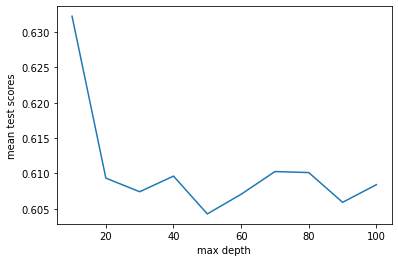

In [168]:
plt.plot([10, 20, 30, 40, 50, 60, 70, 80, 90, 100],grid_im.cv_results_['mean_test_score'])
plt.xlabel('max depth')
plt.ylabel('mean test scores')

In [169]:
params = {'max_depth':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
grid_im = GridSearchCV(clf, param_grid=params, cv=5)
grid_im.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                       100]})

In [170]:
print(grid_im.best_params_)
print(grid_im.best_score_)
print(grid_im.cv_results_['mean_test_score'])

{'max_depth': 30}
0.7462695973014634
[0.73677454 0.74448516 0.7462696  0.74377072 0.74362827 0.74526978
 0.7429137  0.74519891 0.74526998 0.74441304]


Text(0, 0.5, 'mean test scores')

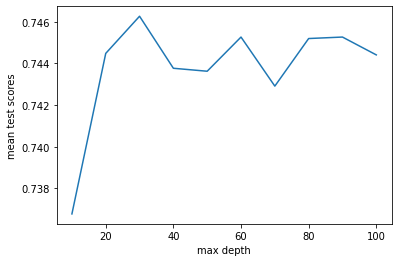

In [171]:
plt.plot([10, 20, 30, 40, 50, 60, 70, 80, 90, 100],grid_im.cv_results_['mean_test_score'])
plt.xlabel('max depth')
plt.ylabel('mean test scores')

Actual Model:

In [276]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [277]:
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler()
X_train_U, y_train_U = undersampler.fit_resample(X_train, y_train)

In [278]:
clf=RandomForestClassifier(max_depth=10)
clf.fit(X_train_U, y_train_U)
y_pred_rf = clf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.52      0.69      0.59       226
           1       0.64      0.80      0.71       225
           2       0.41      0.74      0.53       201
           3       0.53      0.71      0.61       213
           4       0.48      0.64      0.55       216
           5       0.52      0.69      0.60       196
           6       0.52      0.74      0.61       231
           7       0.45      0.69      0.54       187
           8       0.91      0.55      0.69      1807

    accuracy                           0.63      3502
   macro avg       0.55      0.70      0.60      3502
weighted avg       0.72      0.63      0.64      3502



Text(0.5, 33.0, 'Predicted')

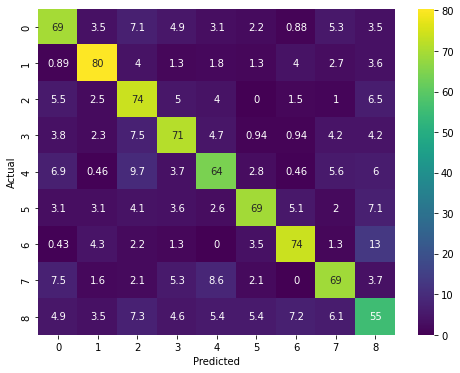

In [279]:
import pandas as pd
import seaborn as sns
confusion_matrix = np.zeros((9, 9), dtype = np.float64)
for i in range(len(y_test)):
  predicted = y_pred_rf[i]
  actual = y_test[i]
  confusion_matrix[actual][predicted] += 1
  _, counts = np.unique(y_test, return_counts = True)
for row in range(9):
  for col in range(9):
    confusion_matrix[row][col] /= counts[row]
    confusion_matrix[row][col] *= 100
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix, annot = True, cmap='viridis', ax = ax)
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

Without undersampling

In [280]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [281]:
clf=RandomForestClassifier(max_depth=30)
clf.fit(X_train, y_train)
y_pred_rf = clf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.69      0.58      0.63       226
           1       0.83      0.72      0.77       225
           2       0.70      0.50      0.58       201
           3       0.71      0.59      0.65       213
           4       0.63      0.50      0.56       216
           5       0.74      0.49      0.59       196
           6       0.77      0.53      0.63       231
           7       0.63      0.56      0.59       187
           8       0.75      0.90      0.82      1807

    accuracy                           0.74      3502
   macro avg       0.72      0.60      0.65      3502
weighted avg       0.73      0.74      0.73      3502



Text(0.5, 33.0, 'Predicted')

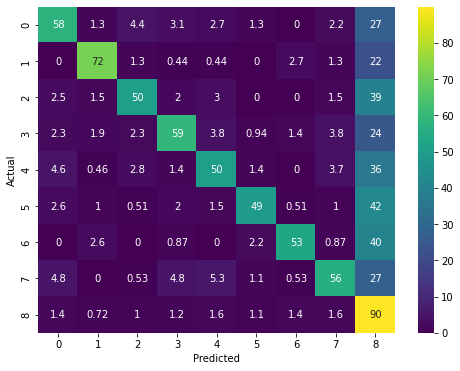

In [282]:
import pandas as pd
import seaborn as sns
confusion_matrix = np.zeros((9, 9), dtype = np.float64)
for i in range(len(y_test)):
  predicted = y_pred_rf[i]
  actual = y_test[i]
  confusion_matrix[actual][predicted] += 1
  _, counts = np.unique(y_test, return_counts = True)
for row in range(9):
  for col in range(9):
    confusion_matrix[row][col] /= counts[row]
    confusion_matrix[row][col] *= 100
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix, annot = True, cmap='viridis', ax = ax)
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

#Random Forest on engineered features with LDA with CV and Undersampling

In [174]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(LDA_features, labels.numpy(), test_size=0.2)

In [175]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [176]:
undersampler = RandomUnderSampler()
clf=RandomForestClassifier()
im_pipeline = make_pipeline(undersampler, clf)
print(im_pipeline.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'randomundersampler', 'randomforestclassifier', 'randomundersampler__random_state', 'randomundersampler__replacement', 'randomundersampler__sampling_strategy', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__max_samples', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_samples_leaf', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__min_weight_fraction_leaf', 'randomforestclassifier__n_estimators', 'randomforestclassifier__n_jobs', 'randomforestclassifier__oob_score', 'randomforestclassifier__random_state', 'randomforestclassifier__verbose', 'randomforestclassifier__warm_start'])


In [177]:
params = {'randomforestclassifier__max_depth':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
grid_im = GridSearchCV(im_pipeline, param_grid=params, cv=5)
grid_im.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('randomundersampler',
                                        RandomUnderSampler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             param_grid={'randomforestclassifier__max_depth': [10, 20, 30, 40,
                                                               50, 60, 70, 80,
                                                               90, 100]})

In [178]:
print(grid_im.best_params_)
print(grid_im.best_score_)
print(grid_im.cv_results_['mean_test_score'])

{'randomforestclassifier__max_depth': 10}
0.6189063200381428
[0.61890632 0.59984382 0.59791565 0.59556068 0.5994157  0.59691647
 0.59391769 0.59705973 0.59684484 0.60198603]


Text(0, 0.5, 'mean test scores')

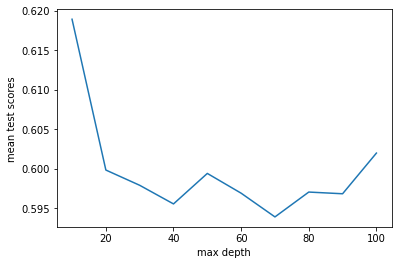

In [179]:
plt.plot([10, 20, 30, 40, 50, 60, 70, 80, 90, 100],grid_im.cv_results_['mean_test_score'])
plt.xlabel('max depth')
plt.ylabel('mean test scores')

In [180]:
params = {'max_depth':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
grid_im = GridSearchCV(clf, param_grid=params, cv=5)
grid_im.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                       100]})

In [181]:
print(grid_im.best_params_)
print(grid_im.best_score_)
print(grid_im.cv_results_['mean_test_score'])

{'max_depth': 50}
0.7454845712541228
[0.73427607 0.74448544 0.74305717 0.7423435  0.74548457 0.74434233
 0.74320051 0.74441375 0.74534159 0.74427082]


Text(0, 0.5, 'mean test scores')

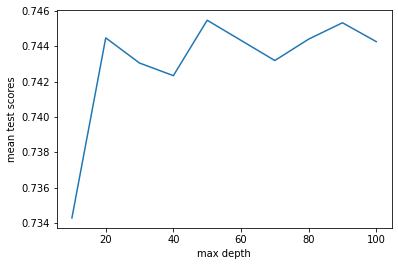

In [182]:
plt.plot([10, 20, 30, 40, 50, 60, 70, 80, 90, 100],grid_im.cv_results_['mean_test_score'])
plt.xlabel('max depth')
plt.ylabel('mean test scores')

Actual Model:

In [283]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [284]:
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler()
X_train_U, y_train_U = undersampler.fit_resample(X_train, y_train)

In [285]:
clf=RandomForestClassifier(max_depth=10)
clf.fit(X_train_U, y_train_U)
y_pred_rf = clf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.48      0.67      0.56       226
           1       0.59      0.82      0.69       225
           2       0.38      0.74      0.51       201
           3       0.52      0.71      0.60       213
           4       0.48      0.63      0.55       216
           5       0.54      0.71      0.62       196
           6       0.51      0.72      0.59       231
           7       0.47      0.71      0.56       187
           8       0.91      0.52      0.66      1807

    accuracy                           0.62      3502
   macro avg       0.54      0.69      0.59      3502
weighted avg       0.71      0.62      0.63      3502



Text(0.5, 33.0, 'Predicted')

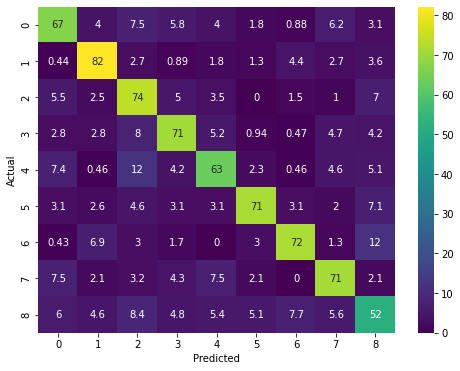

In [286]:
import pandas as pd
import seaborn as sns
confusion_matrix = np.zeros((9, 9), dtype = np.float64)
for i in range(len(y_test)):
  predicted = y_pred_rf[i]
  actual = y_test[i]
  confusion_matrix[actual][predicted] += 1
  _, counts = np.unique(y_test, return_counts = True)
for row in range(9):
  for col in range(9):
    confusion_matrix[row][col] /= counts[row]
    confusion_matrix[row][col] *= 100
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix, annot = True, cmap='viridis', ax = ax)
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

Without undersampling

In [287]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [288]:
clf=RandomForestClassifier(max_depth=50)
clf.fit(X_train, y_train)
y_pred_rf = clf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.67      0.59      0.63       226
           1       0.82      0.69      0.75       225
           2       0.68      0.49      0.57       201
           3       0.72      0.60      0.65       213
           4       0.61      0.51      0.56       216
           5       0.74      0.51      0.60       196
           6       0.79      0.50      0.61       231
           7       0.63      0.59      0.61       187
           8       0.75      0.90      0.82      1807

    accuracy                           0.74      3502
   macro avg       0.71      0.60      0.64      3502
weighted avg       0.73      0.74      0.73      3502



Text(0.5, 33.0, 'Predicted')

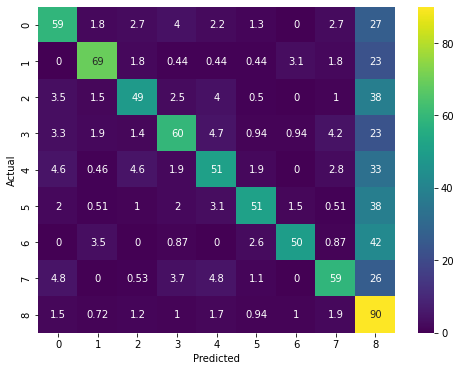

In [289]:
import pandas as pd
import seaborn as sns
confusion_matrix = np.zeros((9, 9), dtype = np.float64)
for i in range(len(y_test)):
  predicted = y_pred_rf[i]
  actual = y_test[i]
  confusion_matrix[actual][predicted] += 1
  _, counts = np.unique(y_test, return_counts = True)
for row in range(9):
  for col in range(9):
    confusion_matrix[row][col] /= counts[row]
    confusion_matrix[row][col] *= 100
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix, annot = True, cmap='viridis', ax = ax)
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

#Logistic Regression on pixels with LDA with CV and Undersampling

In [194]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(LDA_pixels, labels.numpy(), test_size=0.2)

In [195]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression

In [196]:
undersampler = RandomUnderSampler()
clf = LogisticRegression()
im_pipeline = make_pipeline(undersampler, clf)
print(im_pipeline.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'randomundersampler', 'logisticregression', 'randomundersampler__random_state', 'randomundersampler__replacement', 'randomundersampler__sampling_strategy', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticregression__multi_class', 'logisticregression__n_jobs', 'logisticregression__penalty', 'logisticregression__random_state', 'logisticregression__solver', 'logisticregression__tol', 'logisticregression__verbose', 'logisticregression__warm_start'])


In [199]:
params = {'logisticregression__C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
grid_im = GridSearchCV(im_pipeline, param_grid=params, cv=5)
grid_im.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('randomundersampler',
                                        RandomUnderSampler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1,
                                                   10, 100, 1000, 10000,
                                                   100000]})

In [200]:
print(grid_im.best_params_)
print(grid_im.best_score_)
print(grid_im.cv_results_['mean_test_score'])

{'logisticregression__C': 1000}
0.6295414021860757
[0.53051995 0.60662492 0.62882768 0.62882763 0.62711385 0.62854224
 0.62946985 0.6295414  0.62511507 0.62847056]


Text(0, 0.5, 'mean test scores')

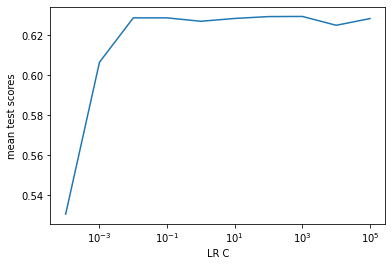

In [201]:
plt.plot([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000],grid_im.cv_results_['mean_test_score'])
plt.xscale("log")
plt.xlabel('LR C')
plt.ylabel('mean test scores')

In [203]:
params = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
grid_im = GridSearchCV(clf, param_grid=params, cv=5)
grid_im.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                               10000, 100000]})

In [204]:
print(grid_im.best_params_)
print(grid_im.best_score_)
print(grid_im.cv_results_['mean_test_score'])

{'C': 0.1}
0.7490531703141607
[0.52023987 0.68365838 0.7452696  0.74905317 0.74869615 0.74898172
 0.74898172 0.74898172 0.74898172 0.74898172]


Text(0, 0.5, 'mean test scores')

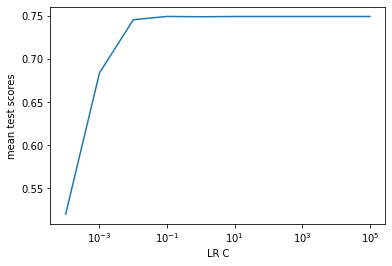

In [205]:
plt.plot([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000],grid_im.cv_results_['mean_test_score'])
plt.xscale("log")
plt.xlabel('LR C')
plt.ylabel('mean test scores')

Actual Model:

In [290]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [291]:
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler()
X_train_U, y_train_U = undersampler.fit_resample(X_train, y_train)

In [292]:
clf = LogisticRegression(C = 0.1)
clf.fit(X_train_U, y_train_U)
y_pred_lr = clf.predict(X_test)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.51      0.71      0.60       226
           1       0.61      0.84      0.71       225
           2       0.45      0.71      0.55       201
           3       0.58      0.76      0.66       213
           4       0.49      0.69      0.57       216
           5       0.52      0.76      0.62       196
           6       0.51      0.76      0.61       231
           7       0.46      0.70      0.55       187
           8       0.91      0.54      0.68      1807

    accuracy                           0.64      3502
   macro avg       0.56      0.72      0.62      3502
weighted avg       0.72      0.64      0.65      3502



Text(0.5, 33.0, 'Predicted')

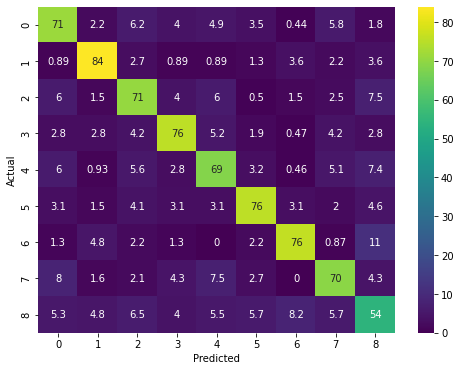

In [293]:
import pandas as pd
import seaborn as sns
confusion_matrix = np.zeros((9, 9), dtype = np.float64)
for i in range(len(y_test)):
  predicted = y_pred_lr[i]
  actual = y_test[i]
  confusion_matrix[actual][predicted] += 1
  _, counts = np.unique(y_test, return_counts = True)
for row in range(9):
  for col in range(9):
    confusion_matrix[row][col] /= counts[row]
    confusion_matrix[row][col] *= 100
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix, annot = True, cmap='viridis', ax = ax)
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

Without undersampling

In [294]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [295]:
clf = LogisticRegression(C = 0.1)
clf.fit(X_train, y_train)
y_pred_lr = clf.predict(X_test)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.67      0.62      0.64       226
           1       0.85      0.73      0.78       225
           2       0.67      0.46      0.55       201
           3       0.75      0.64      0.69       213
           4       0.63      0.54      0.58       216
           5       0.73      0.57      0.64       196
           6       0.80      0.57      0.66       231
           7       0.64      0.59      0.61       187
           8       0.76      0.89      0.82      1807

    accuracy                           0.74      3502
   macro avg       0.72      0.62      0.66      3502
weighted avg       0.74      0.74      0.74      3502



Text(0.5, 33.0, 'Predicted')

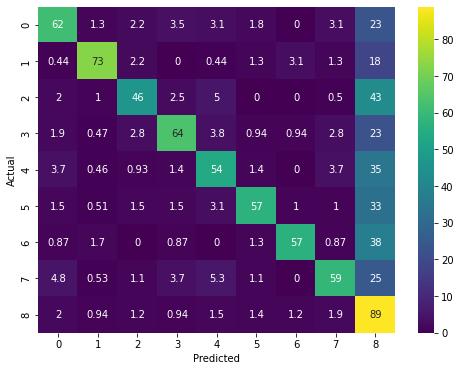

In [296]:
import pandas as pd
import seaborn as sns
confusion_matrix = np.zeros((9, 9), dtype = np.float64)
for i in range(len(y_test)):
  predicted = y_pred_lr[i]
  actual = y_test[i]
  confusion_matrix[actual][predicted] += 1
  _, counts = np.unique(y_test, return_counts = True)
for row in range(9):
  for col in range(9):
    confusion_matrix[row][col] /= counts[row]
    confusion_matrix[row][col] *= 100
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix, annot = True, cmap='viridis', ax = ax)
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

#Logistic Regression on engineered features with LDA with CV and Undersampling

In [211]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(LDA_features, labels.numpy(), test_size=0.2)

In [212]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression

In [213]:
undersampler = RandomUnderSampler()
clf = LogisticRegression()
im_pipeline = make_pipeline(undersampler, clf)
print(im_pipeline.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'randomundersampler', 'logisticregression', 'randomundersampler__random_state', 'randomundersampler__replacement', 'randomundersampler__sampling_strategy', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticregression__multi_class', 'logisticregression__n_jobs', 'logisticregression__penalty', 'logisticregression__random_state', 'logisticregression__solver', 'logisticregression__tol', 'logisticregression__verbose', 'logisticregression__warm_start'])


In [214]:
params = {'logisticregression__C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
grid_im = GridSearchCV(im_pipeline, param_grid=params, cv=5)
grid_im.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('randomundersampler',
                                        RandomUnderSampler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1,
                                                   10, 100, 1000, 10000,
                                                   100000]})

In [215]:
print(grid_im.best_params_)
print(grid_im.best_score_)
print(grid_im.cv_results_['mean_test_score'])

{'logisticregression__C': 10000}
0.6178342546673832
[0.46890855 0.55950633 0.61126637 0.61654941 0.61476459 0.61604981
 0.61626402 0.61776321 0.61783425 0.61662078]


Text(0, 0.5, 'mean test scores')

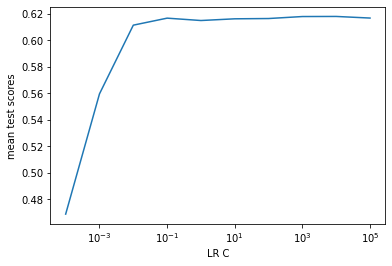

In [216]:
plt.plot([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000],grid_im.cv_results_['mean_test_score'])
plt.xscale("log")
plt.xlabel('LR C')
plt.ylabel('mean test scores')

In [217]:
params = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
grid_im = GridSearchCV(clf, param_grid=params, cv=5)
grid_im.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                               10000, 100000]})

In [218]:
print(grid_im.best_params_)
print(grid_im.best_score_)
print(grid_im.cv_results_['mean_test_score'])

{'C': 0.1}
0.761405901481601
[0.52009711 0.68558624 0.75747894 0.7614059  0.76090623 0.76069207
 0.76069207 0.76069207 0.76069207 0.76069207]


Text(0, 0.5, 'mean test scores')

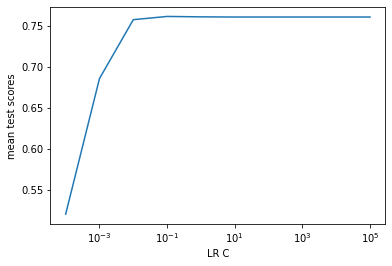

In [219]:
plt.plot([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000],grid_im.cv_results_['mean_test_score'])
plt.xscale("log")
plt.xlabel('LR C')
plt.ylabel('mean test scores')

Actual Model:

In [300]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [301]:
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler()
X_train_U, y_train_U = undersampler.fit_resample(X_train, y_train)

In [302]:
clf = LogisticRegression(C = 0.1)
clf.fit(X_train_U, y_train_U)
y_pred_lr = clf.predict(X_test)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.50      0.72      0.59       226
           1       0.61      0.84      0.71       225
           2       0.45      0.71      0.55       201
           3       0.58      0.76      0.66       213
           4       0.49      0.69      0.57       216
           5       0.52      0.74      0.61       196
           6       0.52      0.76      0.62       231
           7       0.46      0.70      0.55       187
           8       0.91      0.54      0.68      1807

    accuracy                           0.64      3502
   macro avg       0.56      0.72      0.61      3502
weighted avg       0.72      0.64      0.64      3502



Text(0.5, 33.0, 'Predicted')

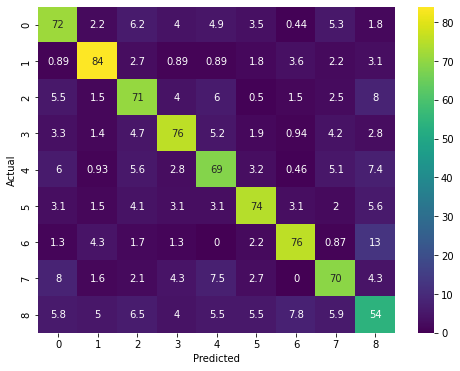

In [303]:
import pandas as pd
import seaborn as sns
confusion_matrix = np.zeros((9, 9), dtype = np.float64)
for i in range(len(y_test)):
  predicted = y_pred_lr[i]
  actual = y_test[i]
  confusion_matrix[actual][predicted] += 1
  _, counts = np.unique(y_test, return_counts = True)
for row in range(9):
  for col in range(9):
    confusion_matrix[row][col] /= counts[row]
    confusion_matrix[row][col] *= 100
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix, annot = True, cmap='viridis', ax = ax)
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

Without undersampling

In [297]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [298]:
clf = LogisticRegression(C = 0.1)
clf.fit(X_train, y_train)
y_pred_lr = clf.predict(X_test)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.67      0.62      0.64       226
           1       0.85      0.73      0.78       225
           2       0.67      0.46      0.55       201
           3       0.75      0.64      0.69       213
           4       0.63      0.54      0.58       216
           5       0.73      0.57      0.64       196
           6       0.80      0.57      0.66       231
           7       0.64      0.59      0.61       187
           8       0.76      0.89      0.82      1807

    accuracy                           0.74      3502
   macro avg       0.72      0.62      0.66      3502
weighted avg       0.74      0.74      0.74      3502



Text(0.5, 33.0, 'Predicted')

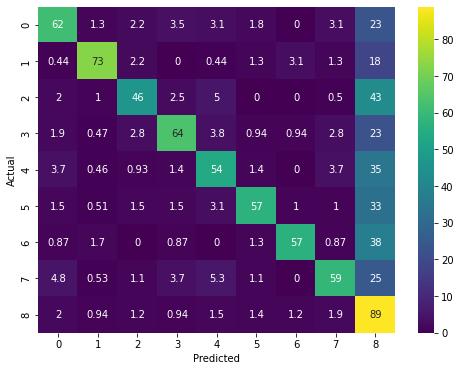

In [299]:
import pandas as pd
import seaborn as sns
confusion_matrix = np.zeros((9, 9), dtype = np.float64)
for i in range(len(y_test)):
  predicted = y_pred_lr[i]
  actual = y_test[i]
  confusion_matrix[actual][predicted] += 1
  _, counts = np.unique(y_test, return_counts = True)
for row in range(9):
  for col in range(9):
    confusion_matrix[row][col] /= counts[row]
    confusion_matrix[row][col] *= 100
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix, annot = True, cmap='viridis', ax = ax)
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")